In [1]:
import sys

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/data"
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots
from tqdm import tqdm
from scipy.stats import qmc, skew, kurtosis
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian

from utils import set_global_seed
from pinn_architecture import PINN
from loss_functions import *
from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

In [2]:
# Define and fix seed
SEED: int = 20
set_global_seed(SEED)

# Specify the parameter to be varied and it's symbol
VARYING_PARAM: str = "inertia"
VARYING_PARAM_NOTATION: str = "m"

# Boolean constant only adds title on subplots on the top most row (first random seed 0)
TOP_PLOT: bool = True

# Specify the range of parameter values
PARAM_LIST: list[float] = [0.00025, 0.0025, 0.025, 0.25, 2.5]
# [0.00015, 0.0015, 0.015, 0.15, 1.5]
DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
# INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])

# Path to save images and flag
PATH_TO_IM_DIR: str = "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick"\
                        f"/dissertation_code/data/visualisations/loss_landscapes/{VARYING_PARAM}/"

SAVE: bool = True

In [3]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

CMAP: str = "seismic"  # Color map for the visualisations

# Move tensors and models to GPU
DEVICE: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 100

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float64
).to(device=DEVICE)

# Boolean constant for whether or not PI controllers included
CONTROLLERS: bool = False

# PINN Hyperparameter constants
LEARNING_RATE: float = 0.01
# SCHEDULER_STEP_SIZE: int = 200
PATIENCE: int = 10
SCHEDULER_FACTOR: float = 0.9
EPOCHS: int = 5_000
N_C: int = 1_000  # Number of collocation points

# PINN soft regularisation weights in the loss function
PHYSICS_WEIGHT: float = 1.0
IC_WEIGHT: float = 1.0

# Specify activation function
ACTIVATION: str = "tanh"

# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1)
collocation_points = LHC.random(n=N_C)
collocation_points = qmc.scale(
    collocation_points, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

collocation_points: torch.tensor = torch.tensor(
    data=collocation_points[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)

In [4]:
numerical_solutions_exact = []
numerical_solutions_noisy = []
numerical_domain = None

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT = 0.1

# Define number of total data points from numerical solution, N
N: int = int((FINALTIME - T0)/(TIMESTEP_FLOAT) + 1)

# Define percentage of total dataset N to select for training
TRAIN_TEST_SPLIT: float = 0.3

for param in PARAM_LIST:

    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=param,
    damping=DAMPING.item(),
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1
    )

    if numerical_domain is None:
        numerical_domain = numerical_times

    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

# Reshape numerical solutions into a rank-2 tensor of shape (No. of params values, 2, N)
numerical_solutions_exact = np.array(numerical_solutions_exact)
numerical_solutions_noisy = np.array(numerical_solutions_noisy)

# Also create PyTorch tensors
numerical_solutions_exact_tensor = torch.tensor(numerical_solutions_exact)
numerical_solutions_noisy_tensor = torch.tensor(numerical_solutions_noisy)
times_tensor = torch.tensor(numerical_domain[:, None].astype(np.float32), requires_grad=True)

# Obtain a random array of index to index the numerical solution on to obtain training data
# for vanilla NN
rand_index = np.random.choice(np.arange(1, N, 1), replace=False, size=int(np.floor(N*TRAIN_TEST_SPLIT)))
rand_index = np.append(rand_index, 0)
rand_index.shape

(61,)

In [5]:
test_indices = np.setdiff1d(np.arange(0, N, 1), rand_index)
assert int(test_indices.shape[0] + rand_index.shape[0]) == N

In [6]:
# Define subspace mesh
LB: int = -5
NUM_VERTICES: int = 40
INCREMENT: float = -2*LB / NUM_VERTICES

alpha_1: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
alpha_2: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(model=PINN(activation=ACTIVATION).to(device=DEVICE)).total_params

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vectors
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into unit vector
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-6
assert torch.norm(input=direction_vec_1) - 1 < 1e-8
assert torch.norm(input=direction_vec_2) - 1 < 1e-8

In [7]:
# Collect all trained PINN models for each parameter
nn_models = []

# Collect training losses across each parameter value
training_losses_per_param = []

# Iterate over all parameter values
for index, _ in enumerate(PARAM_LIST):

    print(f"Param value {index+1}")
    print("----------------------\n")

    # Obtain training data
    times = torch.tensor(
        data=np.array([numerical_domain[id] for id in rand_index])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    # NB: Training data is only the phase angle
    training_data = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 0, id] for id in rand_index])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    # Define PINN, optimiser and learning rate scheduler
    nn = PINN(activation=ACTIVATION).to(device=DEVICE)

    # Instantiate the Adam optimiser and learning rate scheduler
    optimiser = torch.optim.Adam(params=nn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    loss_MSE =torch.nn.MSELoss()

    # Define array to collect training loss every epoch
    training_loss = []

    # Perform the training loop using full-batch training
    for epoch in tqdm(range(EPOCHS)):

        # Obtain PINN predictions and it's time derivatives
        phase_angle_pred = nn.forward(
            data=times, initial_state=INITIAL_STATE
        )

        # Obtain the loss
        loss = loss_MSE(phase_angle_pred, training_data)      
        training_loss.append(loss.item())

        # Backpropogate using reverse/backward-mode AD
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lr_scheduler.step(metrics=loss)

        if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
            print(f"Training loss: {loss}")
    
    # Append the trained model and the training losses per epoch to the respective lists
    nn_models.append(nn)
    training_losses_per_param.append(training_loss)

Param value 1
----------------------



 10%|▉         | 481/5000 [00:00<00:01, 2450.57it/s]

Training loss: 0.6075747013092041
Training loss: 2.96890993922716e-05
Training loss: 5.933679403824499e-06
Training loss: 1.038466166392027e-06
Training loss: 5.120433570482419e-07
Training loss: 4.422261383751902e-07


 20%|█▉        | 998/5000 [00:00<00:01, 2544.79it/s]

Training loss: 3.9796904616196116e-07
Training loss: 3.6001458170176193e-07
Training loss: 3.2687691486898984e-07
Training loss: 2.97781923563889e-07
Training loss: 2.7391675416765793e-07
Training loss: 2.543335710925021e-07


 30%|███       | 1511/5000 [00:00<00:01, 2541.40it/s]

Training loss: 2.845351616542757e-07
Training loss: 2.2318545234156772e-07
Training loss: 2.1113189063726168e-07
Training loss: 2.0223613717007538e-07
Training loss: 1.9093447178875067e-07
Training loss: 1.8267145662775874e-07


 46%|████▌     | 2288/5000 [00:00<00:01, 2553.00it/s]

Training loss: 1.7513229977339506e-07
Training loss: 1.6849510586780525e-07
Training loss: 1.6223701493345288e-07
Training loss: 1.5668220498810115e-07
Training loss: 1.5187771396085736e-07
Training loss: 1.466435151087353e-07


 56%|█████▌    | 2799/5000 [00:01<00:00, 2531.23it/s]

Training loss: 1.4352285404584109e-07
Training loss: 1.3785754049422394e-07
Training loss: 1.338511310677859e-07
Training loss: 1.3008853727569658e-07
Training loss: 1.2704950336228649e-07
Training loss: 1.2303347318720625e-07


 66%|██████▌   | 3308/5000 [00:01<00:00, 2492.78it/s]

Training loss: 1.1968339208578982e-07
Training loss: 1.165868468433473e-07
Training loss: 1.1361425578115814e-07
Training loss: 1.1072703642867054e-07
Training loss: 1.0861645449722346e-07
Training loss: 1.052778557664169e-07


 82%|████████▏ | 4091/5000 [00:01<00:00, 2552.85it/s]

Training loss: 1.0267757488691132e-07
Training loss: 1.0024103858086164e-07
Training loss: 1.0470652966887428e-07
Training loss: 9.55336219021774e-08
Training loss: 9.353824736990646e-08
Training loss: 9.114693710898791e-08


 92%|█████████▏| 4605/5000 [00:01<00:00, 2497.69it/s]

Training loss: 8.972904197435128e-08
Training loss: 8.702951959094207e-08
Training loss: 8.502879467187086e-08
Training loss: 8.3158958830154e-08
Training loss: 8.128381523420103e-08
Training loss: 7.952096581220758e-08


100%|██████████| 5000/5000 [00:01<00:00, 2517.60it/s]


Training loss: 7.77630475568003e-08
Training loss: 7.610096020016499e-08
Param value 2
----------------------



  5%|▌         | 259/5000 [00:00<00:01, 2583.05it/s]

Training loss: 1.8593289852142334
Training loss: 7.537441706517711e-05
Training loss: 3.856330658891238e-05
Training loss: 2.6774050638778135e-05
Training loss: 2.034039789577946e-05
Training loss: 1.5222017282212619e-05


 15%|█▌        | 768/5000 [00:00<00:01, 2497.85it/s]

Training loss: 1.1025180356227793e-05
Training loss: 7.675977030885406e-06
Training loss: 5.116820830153301e-06
Training loss: 3.2740865663072327e-06


 21%|██        | 1031/5000 [00:00<00:01, 2548.12it/s]

Training loss: 2.0380987280077534e-06
Training loss: 1.2658188097702805e-06


 26%|██▌       | 1295/5000 [00:00<00:01, 2580.68it/s]

Training loss: 8.078189353000198e-07
Training loss: 5.401600446930388e-07
Training loss: 3.79178260345725e-07
Training loss: 2.7697404902937706e-07


 31%|███▏      | 1563/5000 [00:00<00:01, 2614.23it/s]

Training loss: 2.0868402828000399e-07
Training loss: 1.6168665695204254e-07


 42%|████▏     | 2085/5000 [00:00<00:01, 2531.75it/s]

Training loss: 1.2905537971619196e-07
Training loss: 1.0646532189184654e-07
Training loss: 9.090079799989326e-08
Training loss: 8.019939201631132e-08
Training loss: 7.280413427679377e-08
Training loss: 6.757066728368955e-08


 52%|█████▏    | 2605/5000 [00:01<00:00, 2546.57it/s]

Training loss: 6.372820138267343e-08
Training loss: 6.075769221070004e-08
Training loss: 5.831741844986027e-08


 57%|█████▋    | 2861/5000 [00:01<00:00, 2495.18it/s]

Training loss: 5.620356802182869e-08
Training loss: 5.4295593798769914e-08


 63%|██████▎   | 3130/5000 [00:01<00:00, 2551.87it/s]

Training loss: 5.251161638852864e-08
Training loss: 5.0812534624355976e-08
Training loss: 4.9202927954183906e-08
Training loss: 4.764116567912424e-08


 68%|██████▊   | 3399/5000 [00:01<00:00, 2592.47it/s]

Training loss: 4.613701065636633e-08
Training loss: 4.468505210297735e-08


 73%|███████▎  | 3671/5000 [00:01<00:00, 2630.12it/s]

Training loss: 4.33837143987148e-08
Training loss: 4.213773507899532e-08
Training loss: 4.102053097199132e-08
Training loss: 3.993421771042449e-08


 79%|███████▉  | 3940/5000 [00:01<00:00, 2645.59it/s]

Training loss: 3.894753675126594e-08
Training loss: 3.800044012791659e-08


 84%|████████▍ | 4209/5000 [00:01<00:00, 2657.32it/s]

Training loss: 3.712042229153667e-08
Training loss: 3.626118783017773e-08
Training loss: 3.5556979582906934e-08
Training loss: 3.466974618504537e-08


 90%|████████▉ | 4483/5000 [00:01<00:00, 2680.19it/s]

Training loss: 3.3930138698679e-08
Training loss: 3.32198482055901e-08


100%|██████████| 5000/5000 [00:01<00:00, 2602.76it/s]


Training loss: 3.255061287177341e-08
Training loss: 3.18944195498716e-08
Training loss: 3.1293122759734615e-08
Param value 3
----------------------



  0%|          | 0/5000 [00:00<?, ?it/s]

Training loss: 2.550400495529175
Training loss: 1.6588963262620382e-05
Training loss: 9.292462891608011e-06


 11%|█         | 550/5000 [00:00<00:01, 2748.85it/s]

Training loss: 6.926400601514615e-06
Training loss: 5.05270645589917e-06
Training loss: 3.5649420624395134e-06
Training loss: 2.4614591893623583e-06


 16%|█▋        | 825/5000 [00:00<00:01, 2745.55it/s]

Training loss: 1.6949169321378577e-06
Training loss: 1.1914976312255021e-06


 22%|██▏       | 1100/5000 [00:00<00:01, 2737.29it/s]

Training loss: 8.766436394580523e-07
Training loss: 6.875052918076108e-07
Training loss: 5.770594384557626e-07
Training loss: 5.131058173901692e-07


 28%|██▊       | 1376/5000 [00:00<00:01, 2745.26it/s]

Training loss: 4.751669564484473e-07
Training loss: 4.511263966833212e-07


 33%|███▎      | 1652/5000 [00:00<00:01, 2748.38it/s]

Training loss: 4.3420493511803215e-07
Training loss: 4.2076743511643144e-07
Training loss: 4.0902989439928206e-07
Training loss: 3.980121050517482e-07


 39%|███▊      | 1929/5000 [00:00<00:01, 2754.41it/s]

Training loss: 3.873037428547832e-07
Training loss: 3.7664443652829505e-07


 44%|████▍     | 2205/5000 [00:00<00:01, 2746.18it/s]

Training loss: 3.658955733953917e-07
Training loss: 3.550211431502248e-07
Training loss: 3.4392004977235047e-07
Training loss: 3.326375122014724e-07


 50%|████▉     | 2480/5000 [00:00<00:00, 2744.87it/s]

Training loss: 3.2114883197209565e-07
Training loss: 3.0945651019465004e-07


 55%|█████▌    | 2755/5000 [00:01<00:00, 2727.38it/s]

Training loss: 2.9759854669464403e-07
Training loss: 2.856069727386057e-07
Training loss: 2.7666453661367996e-07


 61%|██████    | 3030/5000 [00:01<00:00, 2733.75it/s]

Training loss: 2.626067328037607e-07
Training loss: 2.593416752461053e-07
Training loss: 2.416011284367414e-07


 66%|██████▌   | 3304/5000 [00:01<00:00, 2715.16it/s]

Training loss: 2.826743923378672e-07
Training loss: 2.2237752261844435e-07
Training loss: 2.1933851712674368e-07


 72%|███████▏  | 3580/5000 [00:01<00:00, 2726.65it/s]

Training loss: 2.0501677511219896e-07
Training loss: 1.9705532849911833e-07
Training loss: 1.8940663437660987e-07


 83%|████████▎ | 4127/5000 [00:01<00:00, 2728.04it/s]

Training loss: 1.825378319608717e-07
Training loss: 1.7532541107811994e-07
Training loss: 1.9817943552880024e-07
Training loss: 1.6260815982604981e-07


 88%|████████▊ | 4402/5000 [00:01<00:00, 2732.70it/s]

Training loss: 1.58109145331764e-07
Training loss: 1.5120176044547406e-07


 94%|█████████▎| 4676/5000 [00:01<00:00, 2719.18it/s]

Training loss: 1.5780668150000565e-07
Training loss: 1.409930234785861e-07
Training loss: 1.3754717542724393e-07
Training loss: 1.3184231306695438e-07


100%|██████████| 5000/5000 [00:01<00:00, 2731.69it/s]


Training loss: 1.2755593559177214e-07
Param value 4
----------------------



  0%|          | 0/5000 [00:00<?, ?it/s]

Training loss: 0.7652577757835388


  5%|▌         | 270/5000 [00:00<00:01, 2697.68it/s]

Training loss: 0.004922398831695318
Training loss: 0.00033742323284968734
Training loss: 0.0001466179674025625
Training loss: 0.00010368954826844856


 11%|█         | 542/5000 [00:00<00:01, 2710.04it/s]

Training loss: 7.891347195254639e-05
Training loss: 6.690857844660059e-05


 16%|█▋        | 815/5000 [00:00<00:01, 2717.62it/s]

Training loss: 5.620980300591327e-05
Training loss: 4.956937482347712e-05
Training loss: 4.51498017355334e-05
Training loss: 4.005944720120169e-05


 22%|██▏       | 1087/5000 [00:00<00:01, 2697.39it/s]

Training loss: 3.103115886915475e-05
Training loss: 1.6660947949276306e-05


 27%|██▋       | 1362/5000 [00:00<00:01, 2713.92it/s]

Training loss: 1.8726634152699262e-05
Training loss: 1.6328520359820686e-05
Training loss: 1.5603565771016292e-05


 33%|███▎      | 1638/5000 [00:00<00:01, 2728.99it/s]

Training loss: 1.5263316527125426e-05
Training loss: 1.4933253623894416e-05
Training loss: 1.4602942428609822e-05


 38%|███▊      | 1915/5000 [00:00<00:01, 2741.29it/s]

Training loss: 1.4273397937358823e-05
Training loss: 1.3946199942438398e-05
Training loss: 1.362200691801263e-05


 44%|████▍     | 2190/5000 [00:00<00:01, 2712.39it/s]

Training loss: 1.3301955732458737e-05
Training loss: 1.2986598449060693e-05
Training loss: 1.2676696314883884e-05


 55%|█████▍    | 2740/5000 [00:01<00:00, 2731.27it/s]

Training loss: 1.237281958310632e-05
Training loss: 1.2075553058821242e-05
Training loss: 1.1785597052949015e-05
Training loss: 1.1503320820338558e-05
Training loss: 1.1229585652472451e-05


 60%|██████    | 3014/5000 [00:01<00:00, 2732.46it/s]

Training loss: 1.0964829016302247e-05


 66%|██████▌   | 3288/5000 [00:01<00:00, 2721.74it/s]

Training loss: 1.0709810339903925e-05
Training loss: 1.0465202649356797e-05
Training loss: 1.023173717840109e-05
Training loss: 1.0009928701038007e-05
Training loss: 9.800280167837627e-06


 71%|███████   | 3561/5000 [00:01<00:00, 2723.07it/s]

Training loss: 9.603068974683993e-06


 77%|███████▋  | 3834/5000 [00:01<00:00, 2725.10it/s]

Training loss: 9.41877624427434e-06
Training loss: 9.247270099876914e-06
Training loss: 9.088555088965222e-06
Training loss: 8.9420846052235e-06


 82%|████████▏ | 4107/5000 [00:01<00:00, 2724.65it/s]

Training loss: 8.807416634226684e-06
Training loss: 8.68364531925181e-06


 88%|████████▊ | 4380/5000 [00:01<00:00, 2724.62it/s]

Training loss: 8.569786587031558e-06
Training loss: 8.464872735203244e-06
Training loss: 8.36747949506389e-06
Training loss: 8.276583685074002e-06


 93%|█████████▎| 4653/5000 [00:01<00:00, 2706.58it/s]

Training loss: 8.190909284166992e-06
Training loss: 8.109301234071609e-06


100%|██████████| 5000/5000 [00:01<00:00, 2713.76it/s]


Training loss: 8.030718163354322e-06
Param value 5
----------------------



  0%|          | 0/5000 [00:00<?, ?it/s]

Training loss: 1.9176065921783447
Training loss: 0.023083556443452835
Training loss: 0.01265906635671854


  5%|▌         | 264/5000 [00:00<00:01, 2632.03it/s]

Training loss: 0.0001065090109477751
Training loss: 8.509558938385453e-06


 11%|█         | 528/5000 [00:00<00:01, 2634.78it/s]

Training loss: 9.856928045337554e-06
Training loss: 4.468953193281777e-06
Training loss: 4.115208412258653e-06


 16%|█▌        | 792/5000 [00:00<00:01, 2626.64it/s]

Training loss: 3.8125076571304817e-06
Training loss: 3.5273087632958777e-06
Training loss: 3.2917610042204615e-06


 21%|██        | 1058/5000 [00:00<00:01, 2638.04it/s]

Training loss: 3.076915390920476e-06


 26%|██▋       | 1325/5000 [00:00<00:01, 2647.14it/s]

Training loss: 3.094902240263764e-06
Training loss: 2.692783255042741e-06
Training loss: 2.5313140668004053e-06
Training loss: 2.4454800495732343e-06


 32%|███▏      | 1591/5000 [00:00<00:01, 2651.28it/s]

Training loss: 2.2450922187999822e-06
Training loss: 2.1225348518782994e-06


 37%|███▋      | 1859/5000 [00:00<00:01, 2660.33it/s]

Training loss: 2.017161932599265e-06
Training loss: 1.9134872673021164e-06
Training loss: 1.8291495962330373e-06


 43%|████▎     | 2129/5000 [00:00<00:01, 2670.00it/s]

Training loss: 1.7235574887308758e-06
Training loss: 1.6719088762329193e-06
Training loss: 1.5595630884490674e-06


 48%|████▊     | 2398/5000 [00:00<00:00, 2675.40it/s]

Training loss: 1.487483132223133e-06
Training loss: 1.4182810446072835e-06
Training loss: 1.355568201688584e-06


 53%|█████▎    | 2666/5000 [00:01<00:00, 2633.21it/s]

Training loss: 1.2950429209013237e-06
Training loss: 1.2401031881381641e-06


 59%|█████▊    | 2930/5000 [00:01<00:00, 2442.28it/s]

Training loss: 1.187232101074187e-06
Training loss: 1.1385365041860496e-06
Training loss: 1.0948044746328378e-06


 64%|██████▎   | 3178/5000 [00:01<00:00, 2451.01it/s]

Training loss: 1.048582589646685e-06
Training loss: 1.006486172627774e-06
Training loss: 9.700595455797156e-07


 69%|██████▊   | 3427/5000 [00:01<00:00, 2460.94it/s]

Training loss: 9.359326327285089e-07
Training loss: 9.020170637086267e-07


 74%|███████▎  | 3675/5000 [00:01<00:00, 2331.66it/s]

Training loss: 8.909674420465308e-07


 78%|███████▊  | 3921/5000 [00:01<00:00, 2366.82it/s]

Training loss: 8.378142410947476e-07
Training loss: 8.150927897077054e-07
Training loss: 7.798088290655869e-07


 83%|████████▎ | 4173/5000 [00:01<00:00, 2410.38it/s]

Training loss: 7.589353572257096e-07
Training loss: 7.274489348674251e-07
Training loss: 7.046338055261003e-07


 89%|████████▊ | 4429/5000 [00:01<00:00, 2450.94it/s]

Training loss: 6.801332688155526e-07
Training loss: 6.57701946238376e-07
Training loss: 6.369911602632783e-07


 94%|█████████▎| 4679/5000 [00:01<00:00, 2464.18it/s]

Training loss: 6.166216621750209e-07
Training loss: 5.976648935757112e-07
Training loss: 5.79085224217124e-07


100%|██████████| 5000/5000 [00:01<00:00, 2520.70it/s]


In [8]:
# Collect the loss landscapes for both random and Hessian directions for each parameter value
loss_landscapes_random = []

# Iterate over all parameter values
for index, (nn, _) in enumerate(zip(nn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    # Place PINN in evaluation mode
    nn.eval()

    loss_MSE =torch.nn.MSELoss()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(nn.parameters()).detach()

    # Define lists to collect the loss landscapes for random directions
    loss_landscape_random = []

    # Obtain training data
    times = torch.tensor(
        data=np.array([numerical_domain[id] for id in rand_index])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    # NB: Training data is only the phase angle
    training_data = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 0, id] for id in rand_index])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)
    
    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + (i * direction_vec_1) + (j * direction_vec_2)

            vector_to_parameters(vec=perturbation, parameters=nn.parameters())

            phase_angle_pred = nn.forward(
                data=times, initial_state=INITIAL_STATE
            )

            loss_perturb_random = loss_MSE(phase_angle_pred, training_data)
            loss_landscape_random.append(loss_perturb_random.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=nn.parameters())

    loss_landscape_random = np.array(loss_landscape_random).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_random.append(loss_landscape_random)

Param value 1
----------------------

Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [9]:
# Collect the loss landscapes for Hessian directions for each parameter value
loss_landscapes_hessian = []

# Iterate over all parameter values
for index, (nn, _) in enumerate(zip(nn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    # Place PINN in evaluation mode
    nn.eval()

    loss_MSE =torch.nn.MSELoss()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(nn.parameters()).detach()

     # Obtain training data
    times = torch.tensor(
        data=np.array([numerical_domain[id] for id in rand_index])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    # NB: Training data is only the phase angle
    training_data = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 0, id] for id in rand_index])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    # Obtain the eigenvectors of the Hessian matrix of the loss function    
    hessian_comp = hessian(nn, loss_MSE, data=(times, training_data), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Define lists to collect the loss landscapes for eigenvector directions
    loss_landscape_hessian = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            perturbation_hessian = MINIMISER + (i * first_eigenvector) + (j * second_eigenvector)

            vector_to_parameters(vec=perturbation_hessian, parameters=nn.parameters())

            phase_angle_pred = nn.forward(
                data=times, initial_state=INITIAL_STATE
            )

            loss_perturb_hessian = loss_MSE(phase_angle_pred, training_data)
            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=nn.parameters())

    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_hessian.append(loss_landscape_hessian)

Param value 1
----------------------



/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1278.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [10]:
ORIG_LOSS_INDEX: int = NUM_VERTICES//2

# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for loss, random, hessian_ in zip(training_losses_per_param, loss_landscapes_random, loss_landscapes_hessian):

    print(loss[-1])
    print(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])
    print(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])

    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

7.445319027965525e-08
7.445232e-08
7.445232e-08
3.065515841171873e-08
3.065135e-08
3.065135e-08
1.2366754731374385e-07
1.2363067e-07
1.2363067e-07
7.9553483374184e-06
7.954635e-06
7.954635e-06
5.620453293886385e-07
5.618729e-07
5.618729e-07


Saving...


/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)


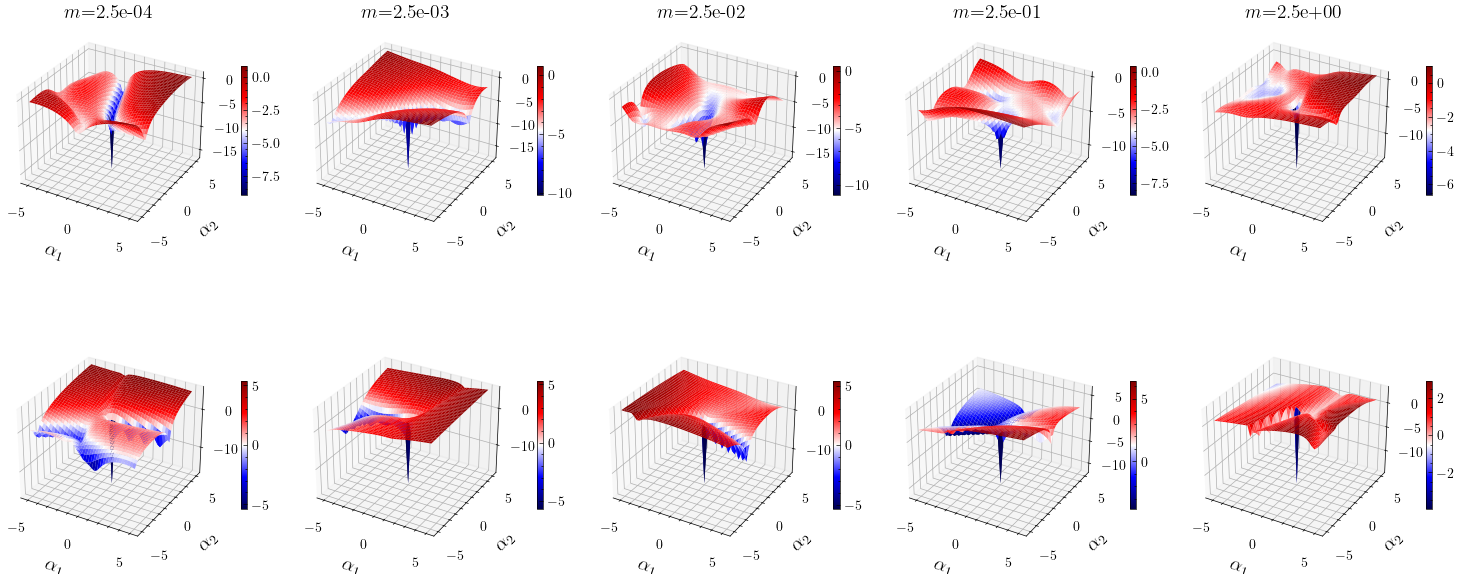

In [11]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(15, 12), subplot_kw={'projection': '3d'})

# Plot the random direction vector subspace projection of the loss landscape
for idx, param in enumerate(PARAM_LIST):
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[idx]),
        cmap=CMAP,
        linewidth=0,
        antialiased=True
    )
    
    fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    # Plot the Hessian eigenvectors subspace projection of the loss landscape
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[idx]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )

    fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=14)
    # ax[1, idx].set_zlim(vmin, vmax)

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

# Output the plots as PDF to the desired directory
loss_landscape_image_name = f"vanilla_nn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

Saving...


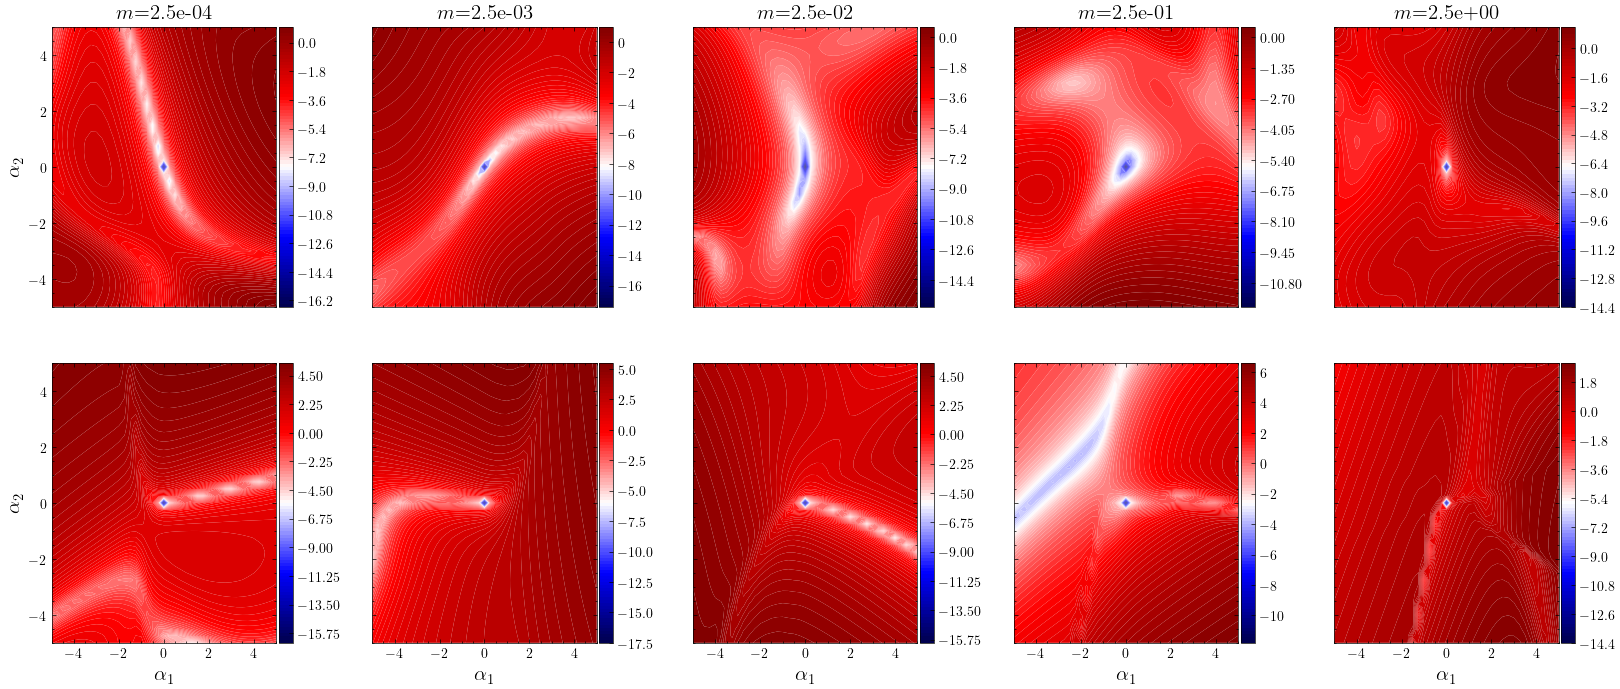

In [12]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels = 100
# levels = np.linspace(vmin, vmax, num_levels)

for index, (param) in enumerate(PARAM_LIST):
    contour_random = ax[0, index].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )
    fig.colorbar(contour_random, ax=ax[0, index], shrink=1, orientation='vertical', pad=0.01)

    
    if index == 0:
        ax[0, index].set_ylabel(r'$\alpha_2$', fontsize=15)
        ax[1, index].set_ylabel(r'$\alpha_2$', fontsize=15)

    if TOP_PLOT:
        ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=15)


    contour_hessian = ax[1, index].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )
    fig.colorbar(contour_hessian, ax=ax[1, index], shrink=1, orientation='vertical', pad=0.01)
    
    ax[1, index].set_xlabel(r'$\alpha_1$', fontsize=15)

# Shared colorbar
# cbar = fig.colorbar(contours_pinn[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)

contour_image_name = f"vanilla_nn/{VARYING_PARAM}_contour_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

<>:75: SyntaxWarning: invalid escape sequence '\d'
<>:76: SyntaxWarning: invalid escape sequence '\d'
<>:75: SyntaxWarning: invalid escape sequence '\d'
<>:76: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_15630/3746241114.py:75: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_15630/3746241114.py:76: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


L2 absolute error: 5.21e-03
L2 relative error: 3.09e-03
L2 absolute error: 2.78e-02
L2 relative error: 2.07e-02
L2 absolute error: 5.83e-02
L2 relative error: 3.69e-02
L2 absolute error: 4.64e-02
L2 relative error: 2.19e-02
L2 absolute error: 1.37e-02
L2 relative error: 7.64e-03
Saving...


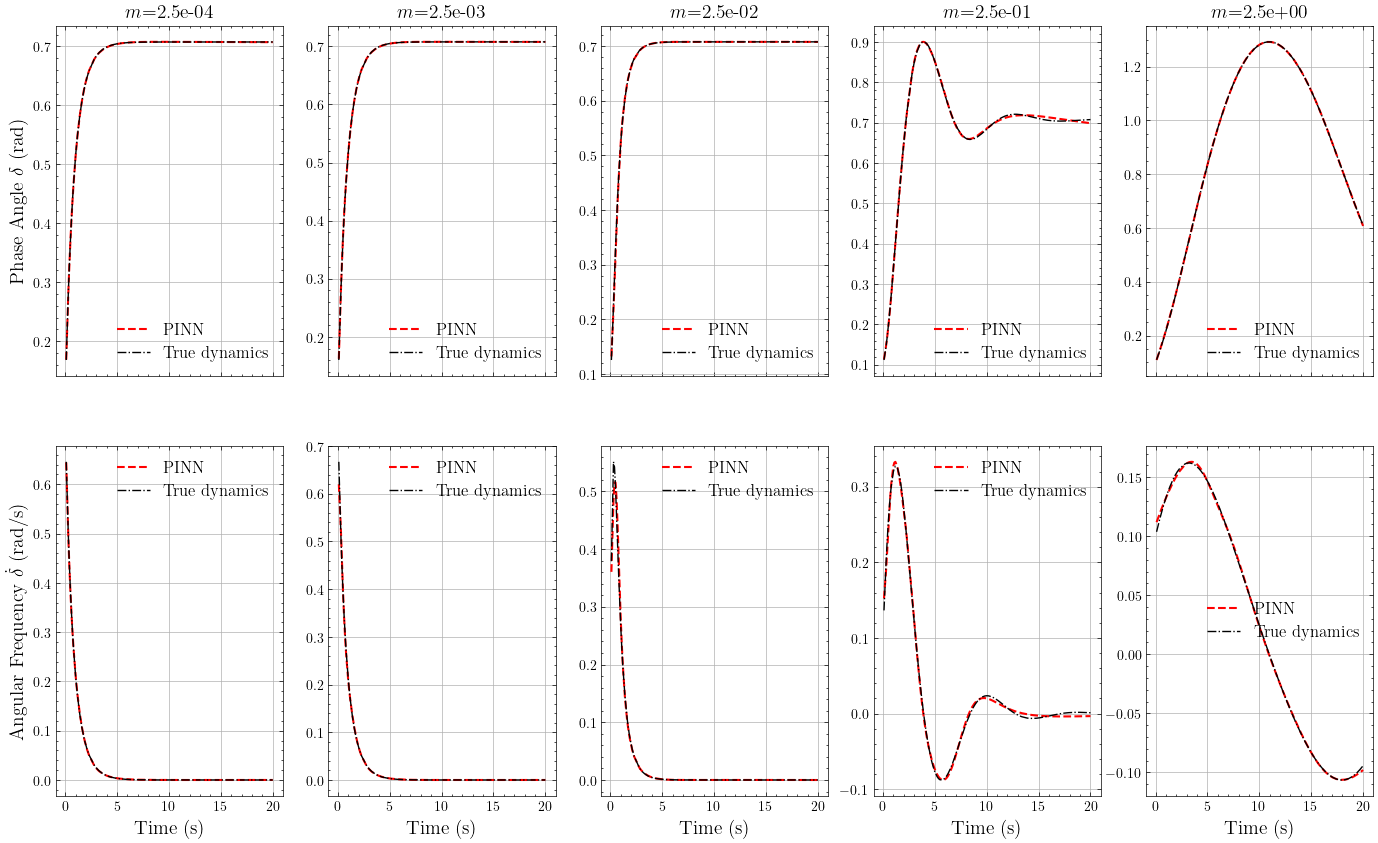

In [ ]:
abs_errors_nns = []
rel_errors_nns = []

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, param in enumerate(PARAM_LIST):

    # phase_angle_labels = numerical_solutions_exact_tensor[index, 0, :]
    # angular_frequency_labels = numerical_solutions_exact_tensor[index, 1, :]

    # Obtain training data for plotting ONLY
    times = np.array([numerical_domain[id] for id in rand_index])

    # NB: Training data is only the phase angle
    training_data = np.array([numerical_solutions_exact[index, 0, id] for id in rand_index])
       
    # Obtain test data
    test_times = torch.tensor(
        data=np.array([numerical_domain[id] for id in test_indices])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    test_data_phase_angle = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 0, id] for id in test_indices])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    test_data_angular_frequency = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 1, id] for id in test_indices])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    # Make NN predictions 
    phase_angle_pred = nn_models[index].forward(data=test_times, initial_state=INITIAL_STATE)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=test_times,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    pred_vector = torch.stack(tensors=(phase_angle_pred, angular_frequency_pred), dim=0).squeeze()
    label_vector = torch.stack(tensors=(test_data_phase_angle, test_data_angular_frequency), dim=0).squeeze()

    assert pred_vector.shape[1] == test_indices.shape[0]
    assert label_vector.shape[1] == test_indices.shape[0]

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"L2 absolute error: {l2_abs:.2e}")
    print(f"L2 relative error: {l2_rel:.2e}")

    abs_errors_nns.append(l2_abs)
    rel_errors_nns.append(l2_rel)

    ax[0, index].plot(test_times.detach().numpy(), phase_angle_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[0, index].plot(test_times.detach().numpy(), test_data_phase_angle, color="black", linestyle="-.", label="True dynamics")
    # ax[0, index].scatter(times, training_data, color="blue", label="Training data", marker='x', alpha=0.5, s=45)   
    ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)
    ax[0, index].grid()

    ax[1, index].plot(test_times.detach().numpy(), angular_frequency_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[1, index].plot(test_times.detach().numpy(), test_data_angular_frequency, color="black", linestyle="-.", label="True dynamics")
    ax[1, index].grid()
    ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)

exact_vs_pred_image: str = f"vanilla_nn/{VARYING_PARAM}_nn_vs_ground_truth_seed_{SEED}.pdf"

# plt.subplots_adjust(left=0.1, right=0.9)
# plt.tight_layout()

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_15630/473602793.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{NN}}$ (log scale)", fontsize=12)


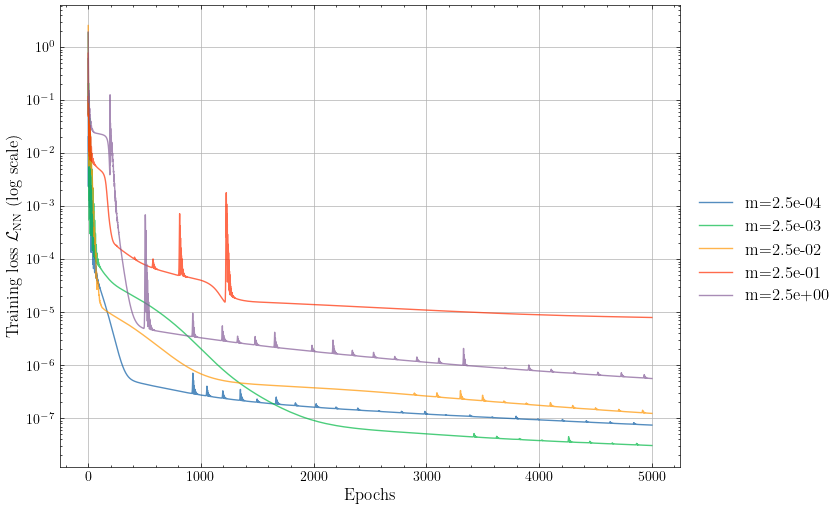

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for (param, training_loss) in zip(PARAM_LIST, training_losses_per_param):
    ax.semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{NN}}$ (log scale)", fontsize=12)
ax.set_xlabel("Epochs", fontsize=12)
ax.grid()
ax.legend(loc="best", fontsize=12, bbox_to_anchor=(1.25, 0.6), borderaxespad=0.)

training_losses_plot = f"{VARYING_PARAM}_training_losses_seed_{SEED}.pdf"

# plt.savefig(fname=PATH_TO_IM_DIR+training_losses_plot, format="pdf", bbox_inches="tight")

plt.show()

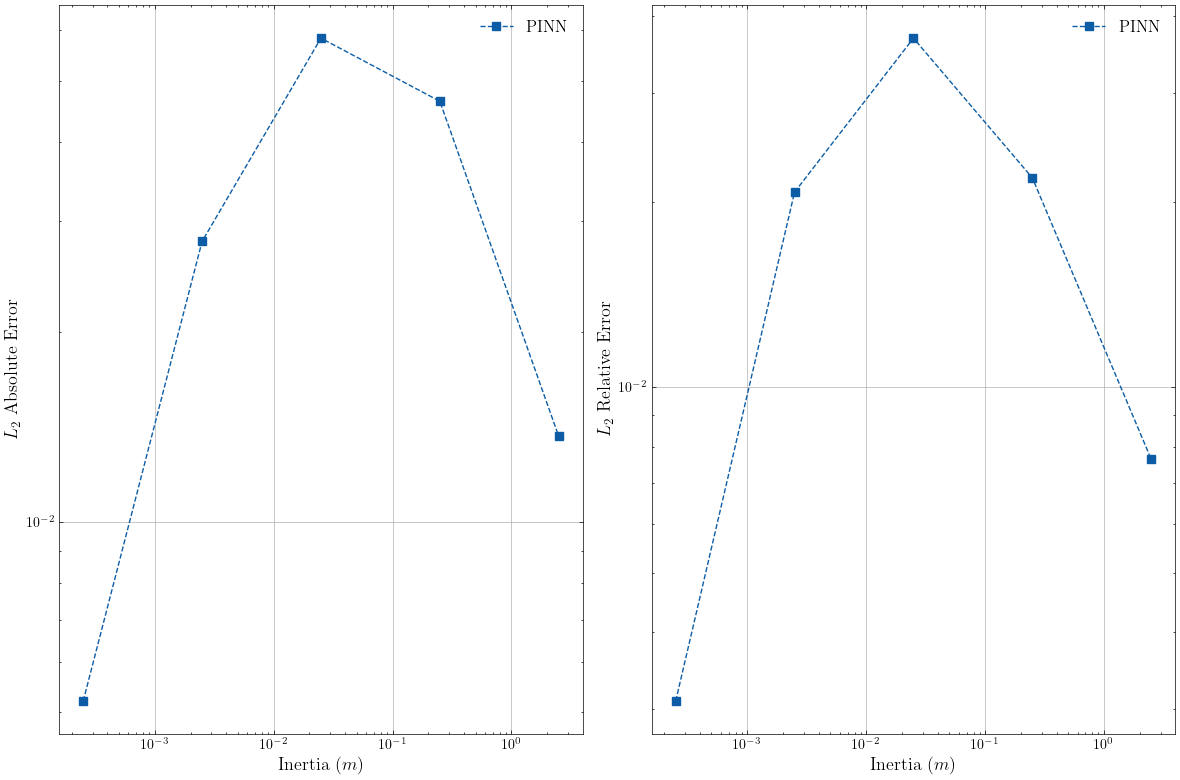

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].loglog(PARAM_LIST, [ls.detach().numpy() for ls in abs_errors_nns], marker='s', linestyle='--', label="PINN")    
ax[0].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[0].set_ylabel("$L_{2}$ Absolute Error", fontsize=13)
ax[0].legend(fontsize=12)
ax[0].grid()

ax[1].loglog(PARAM_LIST, [ls.detach().numpy() for ls in rel_errors_nns], marker='s', linestyle='--', label="PINN")    
ax[1].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[1].set_ylabel("$L_{2}$ Relative Error", fontsize=13)
# ax[1].set_xticklabels()
ax[1].legend(fontsize=12)
ax[1].grid()

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

test_error: str = f"{VARYING_PARAM}_l2_test_error_random_seed_{SEED}.pdf"

# if SAVE:
#     print("Saving...")
#     plt.savefig(fname=PATH_TO_IM_DIR+test_error, format="pdf", bbox_inches="tight")
